<div style="text-align:center">
    <h1>
        Continuous state spaces
    </h1>
</div>

<br><br>

<div style="text-align:center">
    In this notebook we will learn how to adapt tabular methods to continuous state spaces. We will do it with two methods: 
    state aggregation and tile coding.
</div>

<br><br>
<div style="text-align:center">
    <b>This notebook belongs to section 7 of the course "Reinforcement Learning: beginner to master".</b>
    <br><br>
    <a href="https://www.udemy.com">Reinforcement Learning: beginner to master</a> (English)
    <br>
    <a href="https://www.udemy.com">Reinforcement Learning: de principiante a maestro</a> (Spanish)
</div>

<br>

<table style="width:35%">
  <tr style="background-color: transparent">
    <td style="width: 45%">
        <a target="_parent" href="https://www.evlabs.io" style="float: center">
            <img src="img/evlabs-square.png" width="75"/>
        </a> 
    </td>
    <td valign="bottom">
        <a target="_parent" href="https://www.youtube.com/channel/UCksRNSzWuMV5IfdrPlglqqw">
            <img src="img/YouTube.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://www.linkedin.com/company/evlabs">
            <img src="img/LinkedIn.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://twitter.com/evelabs">
            <img src="img/Twitter.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://github.com/escape-velocity-labs/">
            <img src="img/GitHub.png" width="35"/>
        </a> 
    </td>

  </tr>
  <tr style="background-color: transparent">
    <th style="text-align: center; width: 70%">Escape Velocity Labs</th>
  </tr>

</table>

<br>

## Import the necessary software libraries:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import optim
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import clear_output
from pathlib import Path

import random, os.path, math, glob, csv, base64, itertools, sys
import gym
from gym.wrappers import Monitor
from pprint import pprint

# The following code is will be used to visualize the environments.

def show_video(directory):
    html = []
    for mp4 in Path(directory).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))
    
display = Display(visible=0, size=(1400, 900))
display.start();

def make_seed(seed):
    np.random.seed(seed=seed)
    torch.manual_seed(seed=seed)

In [3]:
import random
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from envs import Maze
from utils import plot_policy, plot_tabular_cost_to_go, test_agent, plot_stats, seed_everything

## Implement state aggregation

<br><br>

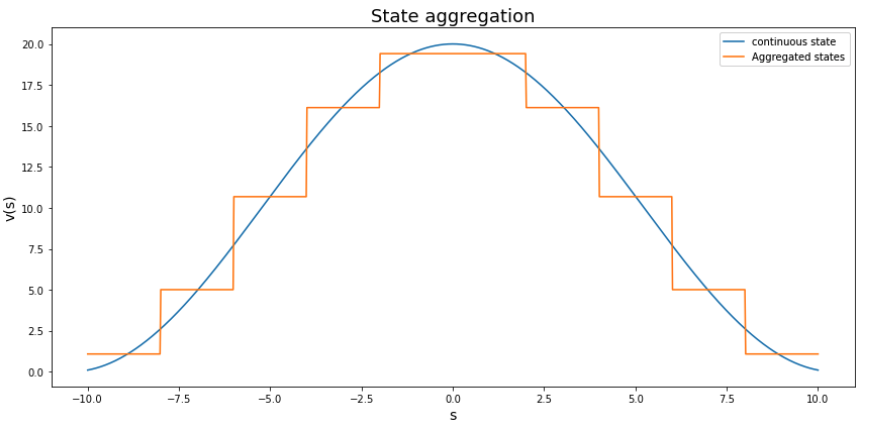

### Create the environment

In [7]:
env = gym.make("MountainCar-v0")
# seed_everything(env)

In [8]:
env.reset()

array([-0.46153054,  0.        ], dtype=float32)

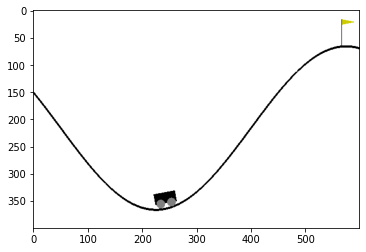

In [9]:
frame = env.render(mode = "rgb_array")
plt.imshow(frame)

### Create the state aggregation wrapper

In [12]:
class StateAggregatorEnv(gym.ObservationWrapper):
    
    def __init__(self, env, bins, low, high):
        # low = [-1.2, -0.07]
        # high = [0.6, 0.07]
        # bins = [20, 20]
        super().__init__(env)
        self.buckets = [np.linspace(l, h, b-1) for l,h, b in zip(low, high, bins) ]
        # [20, 20] -> 400
        self.observation_space = gym.spaces.MultiDiscrete(nvec = bins.tolist())
        
    def observation(self, state):
        # [-1.2, 0] -> (4,3)
        indices = tuple(np.digitize(cont, buck) for cont, buck in zip(state, self.buckets))
        return indices
        

In [13]:
bins = np.array([20, 20])
low = env.observation_space.low
high = env.observation_space.high
saenv = StateAggregatorEnv(env, bins = bins, low = low, high = high)

In [14]:
saenv.buckets

[array([-1.20000005, -1.10000004, -1.00000004, -0.90000004, -0.80000003,
        -0.70000003, -0.60000002, -0.50000002, -0.40000002, -0.30000001,
        -0.20000001, -0.1       ,  0.        ,  0.1       ,  0.20000001,
         0.30000001,  0.40000002,  0.50000002,  0.60000002]),
 array([-0.07      , -0.06222222, -0.05444444, -0.04666667, -0.03888889,
        -0.03111111, -0.02333333, -0.01555556, -0.00777778,  0.        ,
         0.00777778,  0.01555556,  0.02333333,  0.03111111,  0.03888889,
         0.04666667,  0.05444444,  0.06222222,  0.07      ])]

### Compare the original environment to the one with aggregated states

In [15]:
print(f"Modified observation space: {saenv.observation_space}, \n\
Sample state: {saenv.observation_space.sample()}")

Modified observation space: MultiDiscrete([20 20]), 
Sample state: [ 8 10]


In [16]:
print(f"Original observation space: {env.observation_space}, \n\
Sample state: {env.observation_space.sample()}")

Original observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32), 
Sample state: [-1.0383981   0.01288683]


### Create the $Q(s,a)$ value table

In [17]:
action_values = np.zeros((20,20, 3))

### Create the $\epsilon$-greedy policy: $\pi(s)$

In [18]:
def policy(state, epsilon=0.):
    if np.random.random() < epsilon:
        return np.random.randint(3)
    else:
        av = action_values[state]
        return np.random.choice(np.flatnonzero(av == av.max()))

### Test the SARSA algorithm on the modified environment

In [19]:
def sarsa(action_values, policy, episodes, alpha=0.1, gamma=0.99, epsilon=0.2):
    stats = {'Returns': []}
    for episode in tqdm(range(1, episodes + 1)):
        state = saenv.reset()
        action = policy(state, epsilon)
        done = False
        ep_return = 0
        while not done:
            next_state, reward, done, _ = saenv.step(action)
            next_action = policy(next_state, epsilon)
            
            qsa = action_values[state][action]
            next_qsa = action_values[next_state][next_action]
            action_values[state][action] = qsa + alpha * (reward + gamma * next_qsa - qsa)
            state = next_state
            action = next_action
            ep_return += reward
        stats['Returns'].append(ep_return)
    return stats

In [20]:
stats = sarsa(action_values, policy, 20000, alpha=0.1, epsilon=0.)

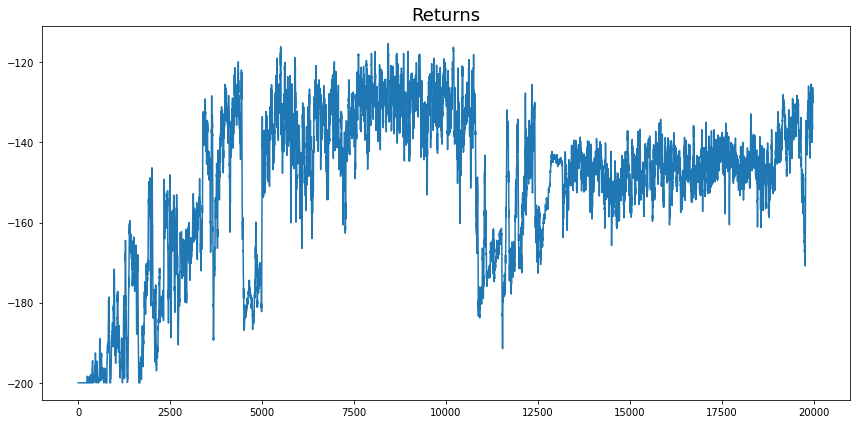

In [21]:
plot_stats(stats)

### Plot the learned policy: $\pi(s)$

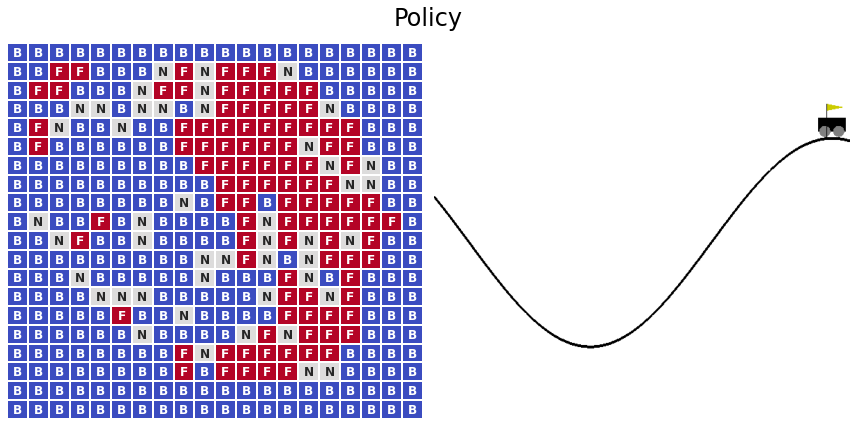

In [22]:
plot_policy(action_values, env.render(mode='rgb_array'), \
            action_meanings={0: 'B', 1: 'N', 2: 'F'})

### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

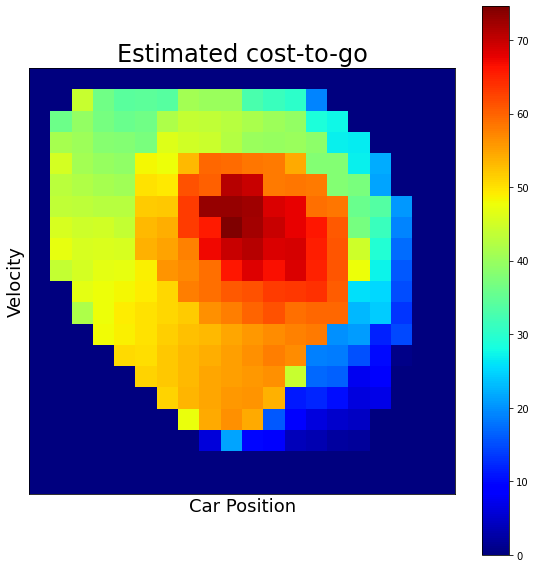

In [23]:
plot_tabular_cost_to_go(action_values, xlabel="Car Position", ylabel="Velocity")

### Test the resulting policy

In [ ]:
test_agent(saenv, policy, 2)

<br><br><br><br>

## Implement Tile Coding

<br><br>

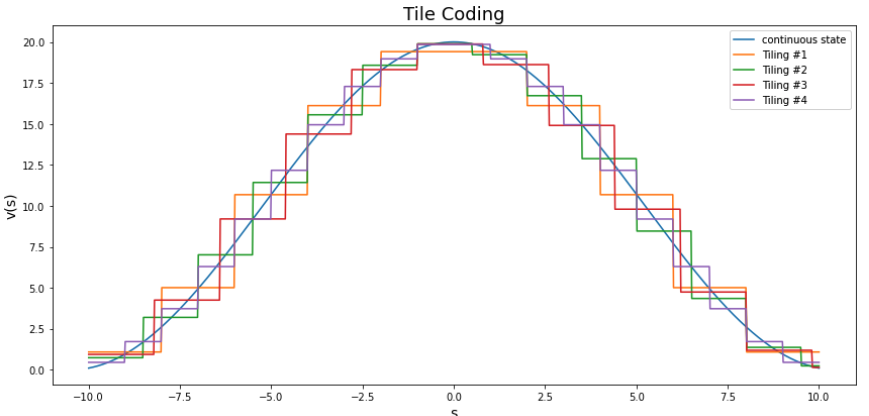

### Create the environment

In [26]:
env = gym.make("MountainCar-v0")
env.reset()

array([-0.49333352,  0.        ], dtype=float32)

### Create the Tile Coding wrapper

In [32]:
class TileAggregatorEnv(gym.ObservationWrapper):
    
    def __init__(self, env, bins, low, high, n):
        # low = [-1.2, -0.07]
        # high = [0.6, 0.07]
        # bins = [20, 20]
        super().__init__(env)
        self.tilings = self.create_tilings(bins, high, low, n)
#         
        # [20, 20] -> 400
        self.observation_space = gym.spaces.MultiDiscrete(nvec = bins.tolist() * n)
        
    def create_tilings(self, bins, high, low, n):
        displacement_vector = np.arange(1, 2 * len(bins), 2) # [1,3]
        tilings = []
        for i in range(1, n+1):
            low_i = low - random.random() * 0.2 * low
            high_i = high - random.random() * 0.2 * high
            segment_sizes = (high_i - low_i) / bins
            displacements = displacement_vector * i % n
            displacements = displacements * (segment_sizes /n)
            low_i += displacements
            high_i += displacements
            buckets_i = [np.linspace(l, h, b-1) for l,h, b in zip(low_i, high_i, bins) ]
            tilings.append(buckets_i)
        return tilings
        
    def observation(self, state):
        # [(5, 4), (5, 3), (4,4), (5,4)]
        indices = []
        for t in self.tilings:
            tiling_indices = tuple(np.digitize(cont, buck) for cont, buck in zip(state, t))
            indices.append(tiling_indices)
        return indices
        

In [33]:
tilings = 4
bins = np.array([20, 20])
low = env.observation_space.low
high = env.observation_space.high

In [34]:
tcenv = TileAggregatorEnv(env, bins = bins, low = low, high = high , n = tilings)

### Compare the original environment to the one with aggregated states

In [35]:
print(f"Modified observation space: {tcenv.observation_space}, \n\
Sample state: {tcenv.reset()}")

Modified observation space: MultiDiscrete([20 20 20 20 20 20 20 20]), 
Sample state: [(6, 9), (7, 9), (6, 9), (6, 9)]


In [36]:
print(f"Original observation space: {env.observation_space}, \n\
Sample state: {env.reset()}")

Original observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32), 
Sample state: [-0.5937906  0.       ]


### Create the $Q(s,a)$ value table

In [37]:
action_values = np.zeros((4, 20, 20, 3))

### Create the $\epsilon$-greedy policy: $\pi(s)$

In [38]:
def policy(state, epsilon=0.):
    if np.random.random() < epsilon:
        return np.random.randint(3)
    else:
        av_list = []
        for i, idx in enumerate(state):
            av = action_values[i][idx]
            av_list.append(av)
        # [[1,2,3], [4,5,6]] -> [2.5, 3.5, 4.5]    
        av = np.mean(av_list, axis=0)
        return np.random.choice(np.flatnonzero(av==av.max()))

### Test the SARSA algorithm on the modified environment

In [39]:
def sarsa(action_values, policy, episodes, alpha=0.1, gamma=0.99, epsilon=0.2):
    stats = {'Returns': []}
    for episode in tqdm(range(1, episodes + 1)):
        state = tcenv.reset()
        action = policy(state, epsilon)
        done = False
        ep_return = 0
        while not done:
            next_state, reward, done, _ = tcenv.step(action)
            next_action = policy(next_state, epsilon)
            
            for i, (idx, next_idx) in enumerate(zip(state, next_state)):
                qsa = action_values[i][idx][action]
                next_qsa = action_values[i][next_idx][next_action]
                action_values[i][idx][action] = qsa + alpha * (reward + gamma * next_qsa - qsa)
            
            state = next_state
            action = next_action
            ep_return += reward
        stats['Returns'].append(ep_return)
    return stats

In [40]:
stats = sarsa(action_values, policy, 20000, alpha=0.1, epsilon=0.)

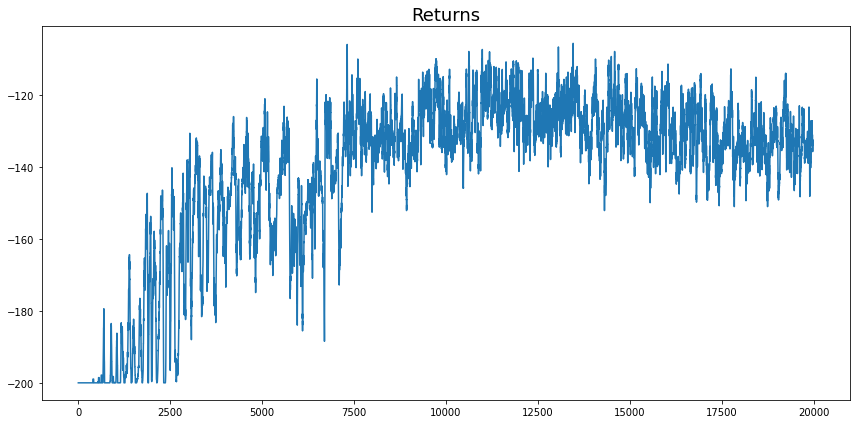

In [41]:
plot_stats(stats)

### Plot the learned policy: $\pi(s)$

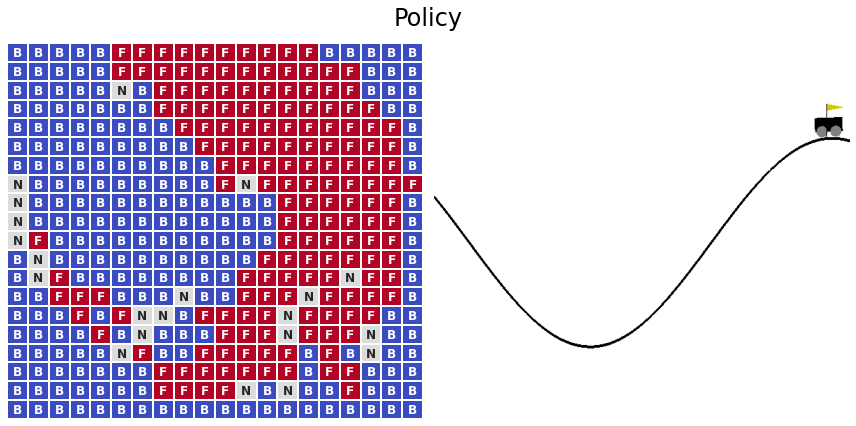

In [42]:
plot_policy(action_values.mean(axis=0), env.render(mode='rgb_array'), \
            action_meanings={0: 'B', 1: 'N', 2: 'F'})

### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

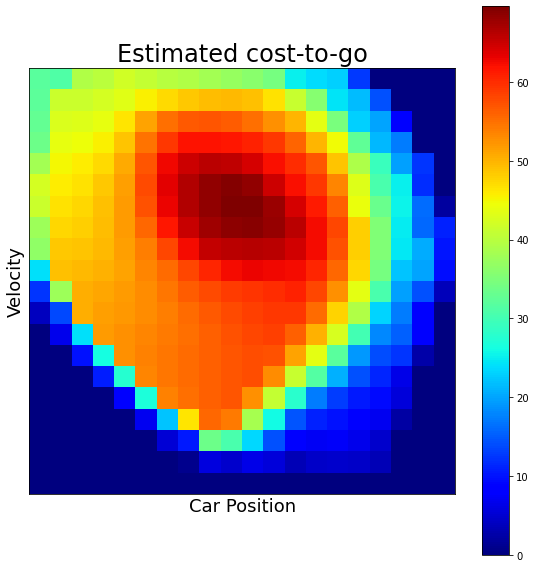

In [43]:
plot_tabular_cost_to_go(action_values.mean(axis=0), \
                        xlabel="Car Position", ylabel="Velocity")

### Test the resulting policy

In [ ]:
test_agent(tcenv, policy, 2)

## Resources

[[1] Reinforcement Learning: An Introduction. Section 9.5.4: Tile Coding](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)